In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**import libraries**

In [2]:
!pip install keras-tuner --upgrade

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from joblib import dump, load
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

In [4]:
#reading data
path = '/content/drive/MyDrive/T5camp/sign_language_project/'

train = pd.read_csv(path + 'sign_mnist_train.csv')
test = pd.read_csv(path + 'sign_mnist_test.csv')

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [6]:
train.shape

(27455, 785)

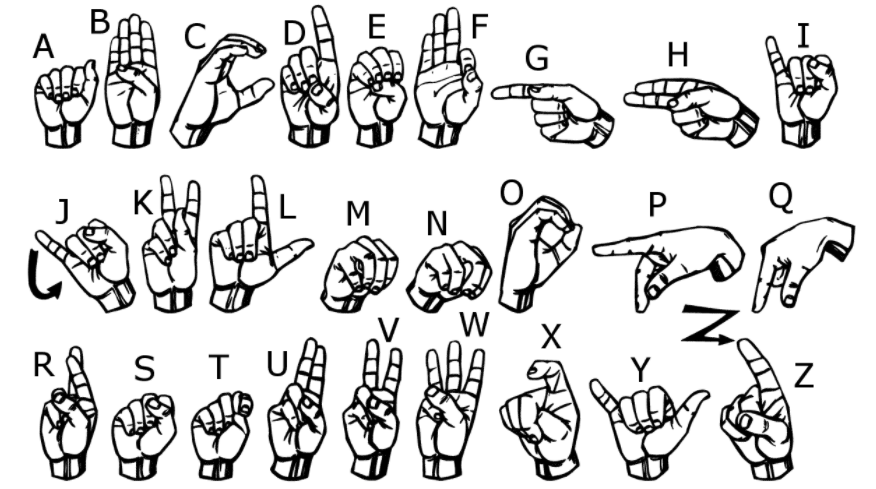

In [7]:
Image("/content/drive/MyDrive/T5camp/sign_language_project/american_sign_language.PNG")

In [8]:
labels = test['label']
y_train = train['label']
y_test = test['label']
del train['label']
del test['label']

In [9]:
def Number_of_digit_classes(labels):
  plt.figure(figsize = (18,8))
  sns.countplot(x =labels, palette="icefire")
  plt.title("Number of digit classes")

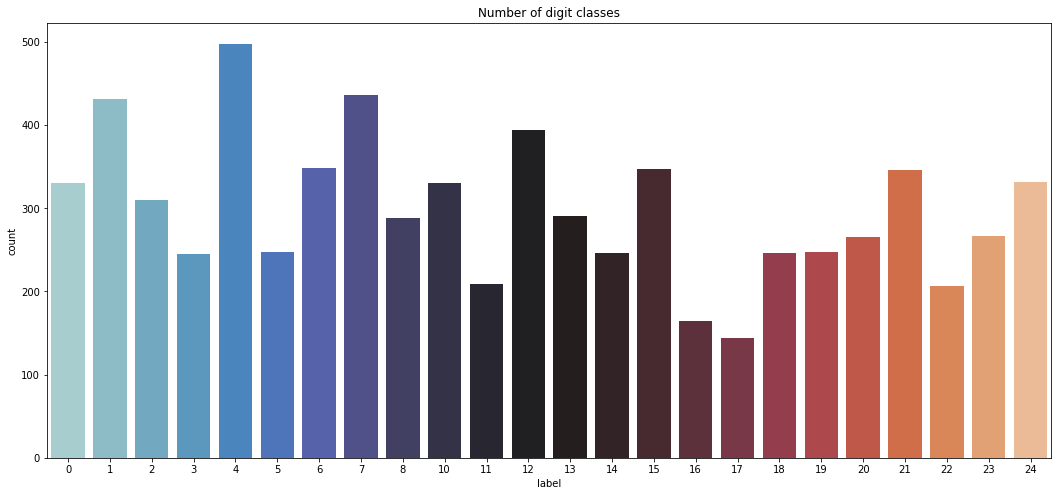

In [10]:
#Data Visualization
Number_of_digit_classes(labels)

In [11]:
#LabelBinarizer it turn every variable into binary within a matrix
def label_binarizer(y_train, y_test):
  label_binarizer = LabelBinarizer()
  y_train = label_binarizer.fit_transform(y_train)
  y_test = label_binarizer.fit_transform(y_test)
  return y_train, y_test

**KNN model**

In [12]:
x_train = train.values
x_test = test.values

In [13]:
knn_classifier = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                      metric_params=None, n_jobs=-1, n_neighbors=5, p=2,weights='uniform')
knn_classifier.fit(x_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [14]:
knnScore = knn_classifier.score(x_train, y_train)
print(knnScore)

0.9992715352394828


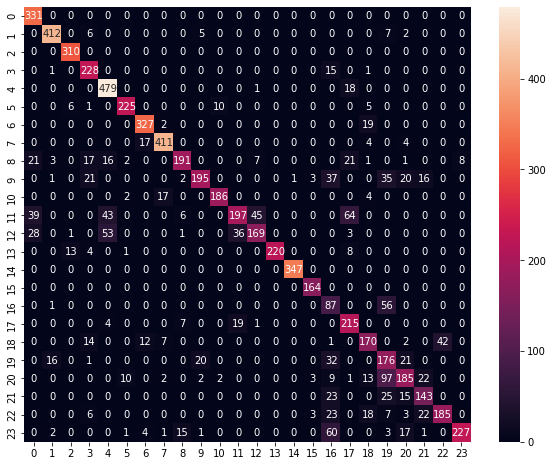

In [15]:
y_ValidPrediction = knn_classifier.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = y_ValidPrediction

Y_true = y_test
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [16]:
x_train = train.values
x_test = test.values

In [17]:
y_train, y_test = label_binarizer(y_train, y_test)

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27455, 784), (27455, 24), (7172, 784), (7172, 24))

In [19]:
def preprocess_image(x):
    x = x/255 #models performs better if we scale pixel values between 0-1
    x = x.reshape(-1,28,28,1) # convertin it into 28 x 28 gray scaled image
    return x

In [20]:
x_train = preprocess_image(x_train)
x_test = preprocess_image(x_test)

In [21]:
def example(x_train):
  f, ax = plt.subplots(2,5) 
  f.set_size_inches(10, 10)
  k = 0
  for i in range(2):
      for j in range(5):
          ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
          k += 1
      plt.tight_layout()    

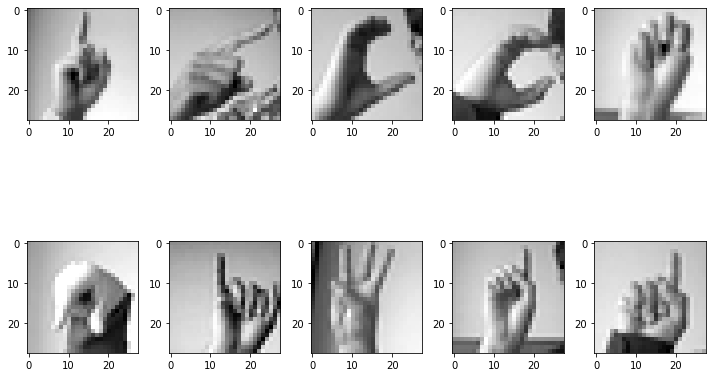

In [22]:
example(x_train)

In [23]:
def labelWithLetter(x_train):
  fig,axe=plt.subplots(2,2)
  fig.suptitle('Preview of dataset')
  axe[0,0].imshow(x_train[0].reshape(28,28),cmap='gray')
  axe[0,0].set_title('label: 3  letter: Y')
  axe[0,1].imshow(x_train[1].reshape(28,28),cmap='gray')
  axe[0,1].set_title('label: 6  letter: A')
  axe[1,0].imshow(x_train[2].reshape(28,28),cmap='gray')
  axe[1,0].set_title('label: 2  letter: G')
  axe[1,1].imshow(x_train[3].reshape(28,28),cmap='gray')
  axe[1,1].set_title('label: 13  letter: M')

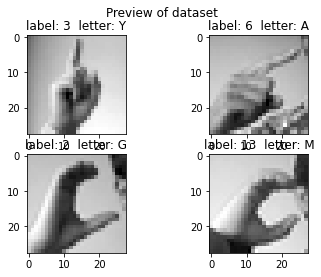

In [24]:
labelWithLetter(x_train)

In [25]:
#data augmentation to prevent overfitting
def datagen():
  datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
  return datagen      

In [26]:
datagen().fit(x_train)

**CNN model**

In [27]:
"""we will be building a CNN model to classify images , as usual we will try a few of 
conv2d layers along with batchNormalization and regulization(dropout) and then fallten layer then dense layer ."""

def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=75, max_value=200, step=25),
        kernel_size=(3,3),
        activation='relu',
        
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=50, max_value=125, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    
    keras.layers.Dropout(
        rate = hp.Choice('drop_1_rate', values = [0.1,0.5])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    
    
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=25, max_value=75, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),  
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    ),
    keras.layers.Dropout(
        rate = hp.Choice('drop_2_rate', values = [0.1,0.3])
    ),
    keras.layers.Dense(24, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [28]:
#search and get the best model
#in other words select the optimal set of hyperparameters for your TensorFlow program
tuner_search=kt.RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ASLdetection1")

In [29]:
 tuner_search.search(x_train,y_train,epochs=10,validation_data = (x_test, y_test))

Trial 5 Complete [00h 35m 23s]
val_accuracy: 0.9742052555084229

Best val_accuracy So Far: 0.9742052555084229
Total elapsed time: 02h 14m 56s
INFO:tensorflow:Oracle triggered exit


In [30]:
model=tuner_search.get_best_models(num_models=1)[0] #this will give us the best tuned model

In [31]:
#You can use callbacks to get a view on internal states and statistics of the model during training.
#we will reduce learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [32]:
#train the model
history = model.fit(datagen().flow(x_train,y_train, batch_size = 128) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 220s 1s/step - loss: 0.2033 - accuracy: 0.9468 - val_loss: 0.0492 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 227s 1s/step - loss: 0.0484 - accuracy: 0.9849 - val_loss: 0.0223 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 229s 1s/step - loss: 0.0320 - accuracy: 0.9897 - val_loss: 0.0115 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 217s 1s/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.1494 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9937
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 202s 937ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.0414 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 6/10
215/215 [==============================] 

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 175)       1750      
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 175)      700       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 175)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 125)       197000    
                                                                 
 dropout (Dropout)           (None, 11, 11, 125)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 125)      5

In [34]:
#Save model
dump(history, 'model.jublib')

INFO:tensorflow:Assets written to: ram://dbd4b81b-f4c3-4713-b790-3cb28004eee4/assets


['model.jublib']

In [35]:
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

858/858 [==============================] - 43s 50ms/step - loss: 3.1475e-04 - accuracy: 1.0000
Accuracy of the model is -  99.99635815620422 %


In [36]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 12s 54ms/step - loss: 0.0019 - accuracy: 0.9994
Accuracy of the model is -  99.94422793388367 %


In [37]:
model.metrics_names
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [38]:
def visual(history):
  epochs = [i for i in range(10)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(16,9)

  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("accuracy")

  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")
  plt.show()

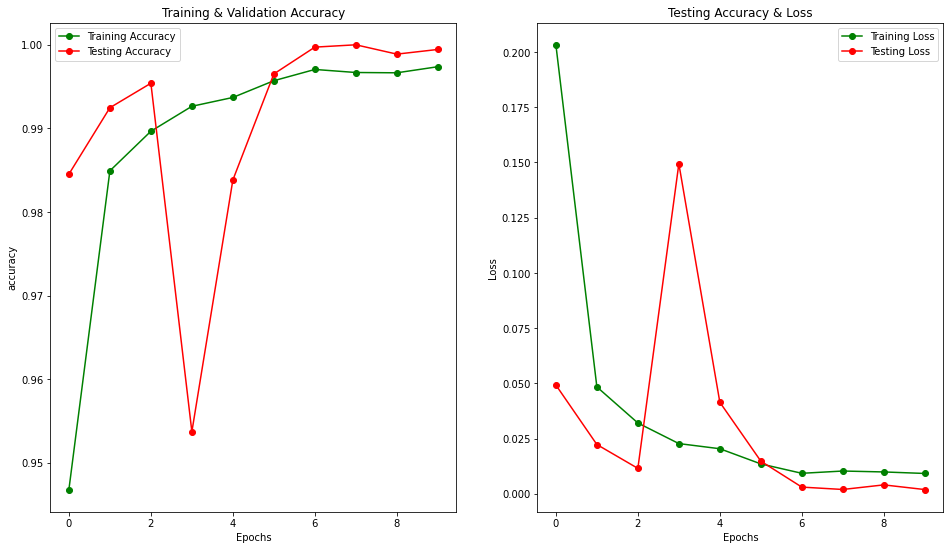

In [39]:
visual(history)

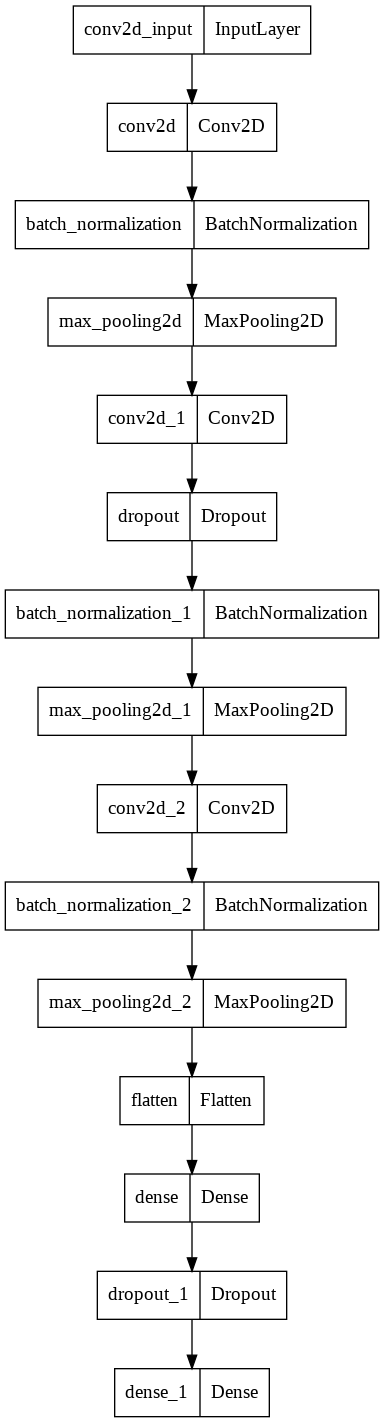

In [40]:
#plot the model architecture
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

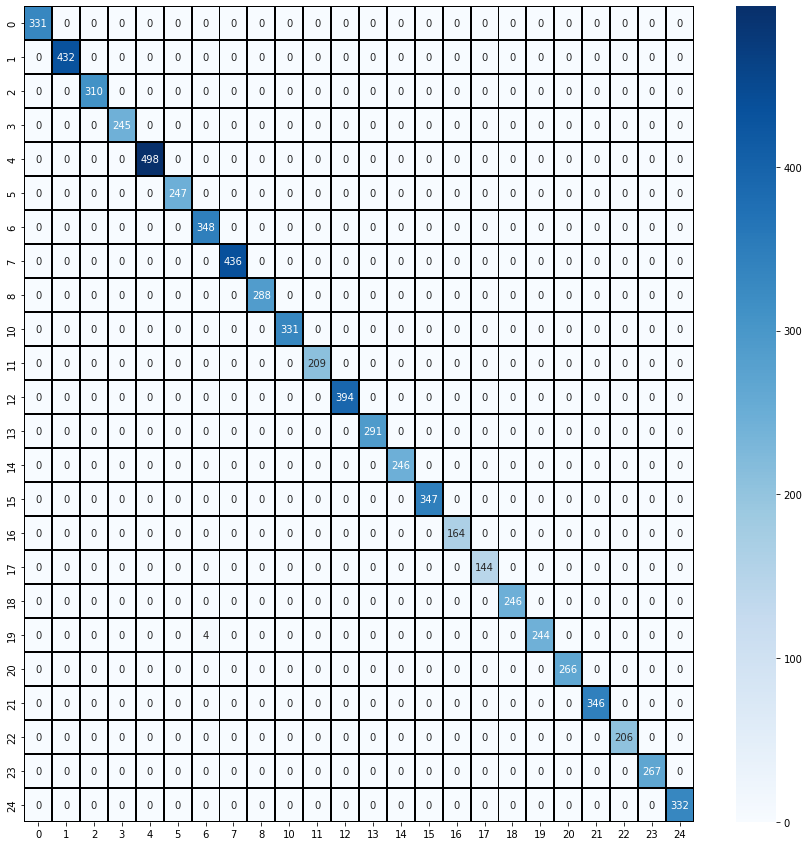

In [41]:
# Confusion Matrix

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx = pd.DataFrame(confusion_mtx , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize = (15,15))
sns.heatmap(confusion_mtx,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [42]:
for i in range(len(Y_pred_classes)):
    if(Y_pred_classes[i] >= 9):
        Y_pred_classes[i] += 1
Y_pred_classes[:5]

array([ 6,  5, 10,  0,  3])

In [43]:
from sklearn.metrics import classification_report
def report(labels, Y_pred_classes):
  classes = ["Class " + str(i) for i in range(25) if i != 9]
  print(classification_report(labels, Y_pred_classes, target_names = classes))

In [44]:
report(labels, Y_pred_classes)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       0.99      1.00      0.99       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [45]:
# correct = np.nonzero(Y_pred == y_test)[0]
# correct

In [46]:
# i = 0
# for c in correct[:6]:
#     plt.subplot(3,2,i+1)
#     plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
#     plt.title("Predicted Class {},Actual Class {}".format(Y_pred[c], labels[c]))
#     plt.tight_layout()
#     i += 1